# 3-1,低阶API示范

下面的范例使用Pytorch的低阶API实现线性回归模型和DNN二分类模型。

低阶API主要包括张量操作，计算图和自动微分。

In [58]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [59]:
import torch 
print("torch.__version__="+torch.__version__) 

torch.__version__=2.0.1


```
torch.__version__=1.10.0
```

### 一，线性回归模型

**1，准备数据**

In [90]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn


#样本数量
n = 400

# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
print("w0.shape:", w0.shape)
Y = X@w0 + b0 + torch.normal(0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动

w0.shape: torch.Size([2, 1])


Text(0, 0.5, 'y')

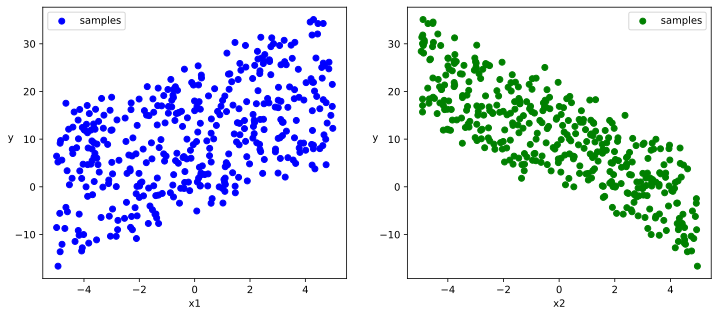

In [97]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

![](./data/3-1-回归数据可视化.png)

In [62]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tensor([[-2.3353,  0.6607],
        [-0.3300, -4.7731],
        [-3.5530,  4.0249],
        [-2.1594, -1.9557],
        [ 0.4069, -1.1676],
        [ 4.4405, -2.9265],
        [ 2.1946, -2.1228],
        [-0.9414,  4.3312]])
tensor([[ 2.6966],
        [20.6788],
        [-9.5643],
        [11.8762],
        [14.7439],
        [26.6000],
        [20.4562],
        [-7.4691]])


```
tensor([[-4.3880,  1.3655],
        [-0.1082,  3.9533],
        [-2.6286,  2.7058],
        [ 1.0604, -1.8646],
        [-1.5805,  1.5406],
        [-2.6217, -3.2342],
        [ 2.3748, -0.6449],
        [-1.2478, -2.0509]])
tensor([[-0.2069],
        [-3.2494],
        [-6.9620],
        [17.0528],
        [ 1.1076],
        [17.2117],
        [16.1081],
        [14.7092]])
```

**2，定义模型**

In [63]:
# 定义模型
class LinearRegression: 
    
    def __init__(self):
        self.w = torch.randn_like(w0,requires_grad=True)
        self.b = torch.zeros_like(b0,requires_grad=True)
        
    #正向传播
    def forward(self,x): 
        return x@self.w + self.b

    # 损失函数
    def loss_fn(self,y_pred,y_true):  
        return torch.mean((y_pred - y_true)**2/2)

model = LinearRegression()

**3，训练模型**

In [64]:
def train_step(model, features, labels):
    
    predictions = model.forward(features)
    loss = model.loss_fn(predictions,labels)
        
    # 反向传播求梯度
    loss.backward()
    
    # 使用torch.no_grad()避免梯度记录，也可以通过操作 model.w.data 实现避免梯度记录 
    with torch.no_grad():
        # 梯度下降法更新参数
        model.w -= 0.001*model.w.grad
        model.b -= 0.001*model.b.grad

        # 梯度清零
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss

In [65]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)


tensor(64.4909, grad_fn=<MeanBackward0>)

```
tensor(92.8199, grad_fn=<MeanBackward0>)
```

In [66]:
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)

        if epoch%20==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss.item())
            print("model.w =",model.w.data)
            print("model.b =",model.b.data)

train_model(model,epochs = 200)



================================================================================2023-05-25 14:01:13
epoch = 20 loss =  12.956146240234375
model.w = tensor([[ 1.8221],
        [-3.0762]])
model.b = tensor([[5.3979]])

================================================================================2023-05-25 14:01:13
epoch = 40 loss =  4.364202499389648
model.w = tensor([[ 1.9072],
        [-3.0356]])
model.b = tensor([[7.8250]])

================================================================================2023-05-25 14:01:13
epoch = 60 loss =  1.5751250982284546
model.w = tensor([[ 1.9433],
        [-3.0165]])
model.b = tensor([[8.9241]])

================================================================================2023-05-25 14:01:14
epoch = 80 loss =  3.064934253692627
model.w = tensor([[ 1.9639],
        [-3.0067]])
model.b = tensor([[9.4218]])

================================================================================2023-05-25 14:01:14
epoch = 100 loss =  2.65816760063

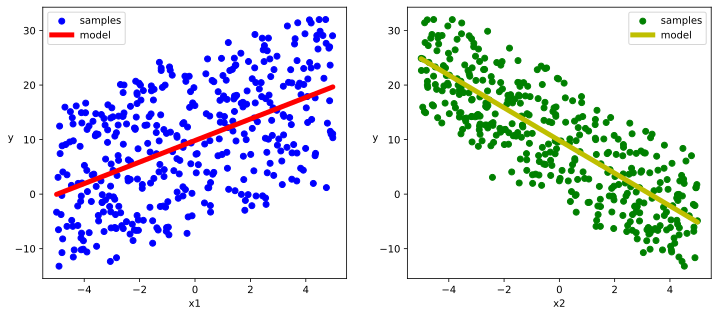

In [74]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.plot(X[:,0].numpy(),(model.w[0].data*X[:,0]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.plot(X[:,1].numpy(),(model.w[1].data*X[:,1]+model.b[0].data).numpy(),"-y",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()


### 二，DNN二分类模型

**1，准备数据**

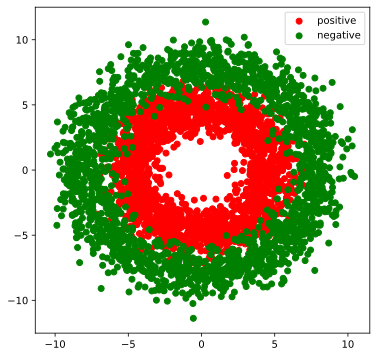

In [75]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

In [76]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)


tensor([[ 7.4512,  0.2930],
        [-5.9321, -0.0758],
        [ 3.6926,  8.2634],
        [ 0.9242,  7.9808],
        [ 0.3531,  5.5017],
        [ 2.2122, -7.8689],
        [-8.2258, -1.4171],
        [ 4.5981,  5.7279]])
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]])


**2，定义模型**

此处范例我们利用nn.Module来组织模型变量。

In [77]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2,4))
        self.b1 = nn.Parameter(torch.zeros(1,4))
        self.w2 = nn.Parameter(torch.randn(4,8))
        self.b2 = nn.Parameter(torch.zeros(1,8))
        self.w3 = nn.Parameter(torch.randn(8,1))
        self.b3 = nn.Parameter(torch.zeros(1,1))

    # 正向传播
    def forward(self,x):
        x = torch.relu(x@self.w1 + self.b1)
        x = torch.relu(x@self.w2 + self.b2)
        y = torch.sigmoid(x@self.w3 + self.b3)
        return y
    
    # 损失函数(二元交叉熵)
    def loss_fn(self,y_pred,y_true):  
        #将预测值限制在1e-7以上, 1- (1e-7)以下，避免log(0)错误
        eps = 1e-7
        y_pred = torch.clamp(y_pred,eps,1.0-eps)
        bce = - y_true*torch.log(y_pred) - (1-y_true)*torch.log(1-y_pred)
        return torch.mean(bce)
    
    # 评估指标(准确率)
    def metric_fn(self,y_pred,y_true):
        y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                          torch.zeros_like(y_pred,dtype = torch.float32))
        acc = torch.mean(1-torch.abs(y_true-y_pred))
        return acc
    
model = DNNModel()

In [78]:
# 测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)

loss = model.loss_fn(labels,predictions)
metric = model.metric_fn(labels,predictions)

print("init loss:", loss.item())
print("init metric:", metric.item())


init loss: 6.315406799316406
init metric: 0.6064364910125732


In [79]:
len(list(model.parameters()))

6

```
6
```

**3，训练模型**

In [80]:
def train_step(model, features, labels):   
    
    # 正向传播求损失
    predictions = model.forward(features)
    loss = model.loss_fn(predictions,labels)
    metric = model.metric_fn(predictions,labels)
        
    # 反向传播求梯度
    loss.backward()
    
    # 梯度下降法更新参数
    for param in model.parameters():
        #注意是对param.data进行重新赋值,避免此处操作引起梯度记录
        param.data = (param.data - 0.01*param.grad.data) 
        
    # 梯度清零
    model.zero_grad()
        
    return loss.item(),metric.item()
 

def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        loss_list,metric_list = [],[]
        for features, labels in data_iter(X,Y,20):
            lossi,metrici = train_step(model,features,labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch%10==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss,"metric = ",metric)
        
train_model(model,epochs = 100)



================================================================================2023-05-25 14:25:35
epoch = 10 loss =  0.4753545415401459 metric =  0.8060000017285347

================================================================================2023-05-25 14:25:37
epoch = 20 loss =  0.3787228585034609 metric =  0.8512499994039535

================================================================================2023-05-25 14:25:38
epoch = 30 loss =  0.21282038427889347 metric =  0.9214999940991402

================================================================================2023-05-25 14:25:40
epoch = 40 loss =  0.19450951984152198 metric =  0.9202499940991402

================================================================================2023-05-25 14:25:42
epoch = 50 loss =  0.18841101736761628 metric =  0.9242499941587448

================================================================================2023-05-25 14:25:43
epoch = 60 loss =  0.1852049299515784 metric =  0.922249

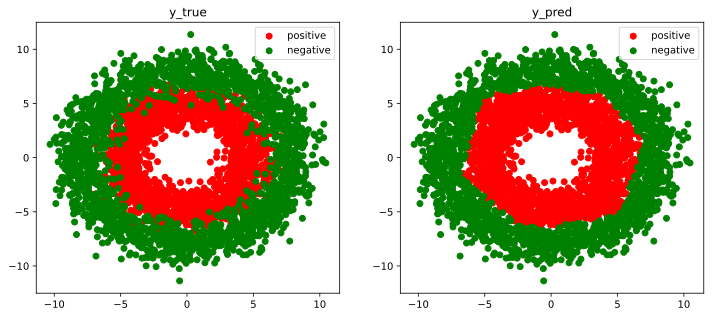

In [83]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");
# tmp1 = model.forward(X)>=0.5
# tmp2 = torch.squeeze(model.forward(X)>=0.5)
Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)